In [1]:
!pip install vaderSentiment
!pip install prettytable

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.8 MB/s eta 0:00:0000:01


In [2]:
import pandas as pd
import numpy as np
import re
import random
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from xgboost import XGBClassifier
import lightgbm as lgb
from prettytable import PrettyTable
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import nltk
from nltk.tokenize import word_tokenize
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
nltk.download('stopwords')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
df = pd.read_csv('/kaggle/input/airline-reviews/Airline_Reviews.csv').drop(['Unnamed: 0'], axis=1).drop_duplicates()
df

,Airline Name,Overall_Rating,Review_Title,Review Date,Verified,Review,Aircraft,Type Of Traveller,Seat Type,Route,Date Flown,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Inflight Entertainment,Wifi & Connectivity,Value For Money,Recommended
0,AB Aviation,9,"""pretty decent airline""",11th November 2019,True,Moroni to Moheli. Turned out to be a pretty ...,NaN,Solo Leisure,Economy Class,Moroni to Moheli,November 2019,4.0,5.0,4.0,4.0,NaN,NaN,3.0,yes
1,AB Aviation,1,"""Not a good airline""",25th June 2019,True,Moroni to Anjouan. It is a very small airline...,E120,Solo Leisure,Economy Class,Moroni to Anjouan,June 2019,2.0,2.0,1.0,1.0,NaN,NaN,2.0,no
2,AB Aviation,1,"""flight was fortunately short""",25th June 2019,True,Anjouan to Dzaoudzi. A very small airline an...,Embraer E120,Solo Leisure,Economy Class,Anjouan to Dzaoudzi,June 2019,2.0,1.0,1.0,1.0,NaN,NaN,2.0,no
3,Adria Airways,1,"""I will never fly again with Adria""",28th September 2019,False,Please do a favor yourself and do not fly wi...,NaN,Solo Leisure,Economy Class,Frankfurt to Pristina,September 2019,1.0,1.0,NaN,1.0,NaN,NaN,1.0,no
4,Adria Airways,1,"""it ruined our last days of holidays""",24th September 2019,True,Do not book a flight with this airline! My fr...,NaN,Couple Leisure,Economy Class,Sofia to Amsterdam via Ljubljana,September 2019,1.0,1.0,1.0,1.0,1.0,1.0,1.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23166,ZIPAIR,1,"""customer service is terrible""",5th July 2022,False,Bangkok to Tokyo. I’ve flown many low cost ai...,NaN,Couple Leisure,Economy Class,Bangkok to Tokyo,June 2022,2.0,1.0,NaN,1.0,1.0,1.0,1.0,no
23167,ZIPAIR,1,"""Avoid at all costs""",1st June 2022,True,Avoid at all costs. I booked flights to go f...,NaN,Solo Leisure,Economy Class,Singapore to Tokyo,June 2022,NaN,NaN,NaN,NaN,NaN,NaN,1.0,no
23168,ZIPAIR,3,"""Will not recommend to anyone""",31st May 2022,True,Flight was leaving at 23.15 and after an hou...,NaN,Business,Economy Class,Bangkok to Tokyo,May 2022,2.0,4.0,2.0,1.0,NaN,NaN,2.0,no
23169,ZIPAIR,6,"""It was immaculately clean""",23rd May 2022,True,Zipair is JAL’s budget airline. They don’t ha...,Dreamliner,Business,Business Class,Tokyo to Los Angeles,May 2022,3.0,4.0,3.0,1.0,2.0,5.0,5.0,yes


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23051 entries, 0 to 23170
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Airline Name            23051 non-null  object 
 1   Overall_Rating          23051 non-null  object 
 2   Review_Title            23051 non-null  object 
 3   Review Date             23051 non-null  object 
 4   Verified                23051 non-null  bool   
 5   Review                  23051 non-null  object 
 6   Aircraft                7127 non-null   object 
 7   Type Of Traveller       19424 non-null  object 
 8   Seat Type               22062 non-null  object 
 9   Route                   19335 non-null  object 
 10  Date Flown              19409 non-null  object 
 11  Seat Comfort            19007 non-null  float64
 12  Cabin Staff Service     18902 non-null  float64
 13  Food & Beverages        14496 non-null  float64
 14  Ground Service          18369 non-null  flo

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Seat Comfort,19007.0,2.618456,1.464854,0.0,1.0,3.0,4.0,5.0
Cabin Staff Service,18902.0,2.871601,1.604669,0.0,1.0,3.0,4.0,5.0
Food & Beverages,14496.0,2.553463,1.526326,0.0,1.0,2.0,4.0,5.0
Ground Service,18369.0,2.353911,1.595846,1.0,1.0,1.0,4.0,5.0
Inflight Entertainment,10827.0,2.179182,1.488809,0.0,1.0,2.0,3.0,5.0
Wifi & Connectivity,5918.0,1.780669,1.318945,0.0,1.0,1.0,2.0,5.0
Value For Money,22092.0,2.450887,1.594229,0.0,1.0,2.0,4.0,5.0


In [6]:
df['Recommended'].value_counts()

Recommended
no     15251
yes     7800
Name: count, dtype: int64

In [7]:
unique_airline_counts = df['Airline Name'].value_counts()
unique_airline_counts

Airline Name
Jet2.com              100
Brussels Airlines     100
Bulgaria Air          100
SpiceJet              100
Southwest Airlines    100
                     ... 
Iberojet                1
Air Labrador            1
Nile Air                1
NextJet                 1
EWA Air                 1
Name: count, Length: 497, dtype: int64

In [8]:
df.isnull().sum()

Airline Name                  0
Overall_Rating                0
Review_Title                  0
Review Date                   0
Verified                      0
Review                        0
Aircraft                  15924
Type Of Traveller          3627
Seat Type                   989
Route                      3716
Date Flown                 3642
Seat Comfort               4044
Cabin Staff Service        4149
Food & Beverages           8555
Ground Service             4682
Inflight Entertainment    12224
Wifi & Connectivity       17133
Value For Money             959
Recommended                   0
dtype: int64

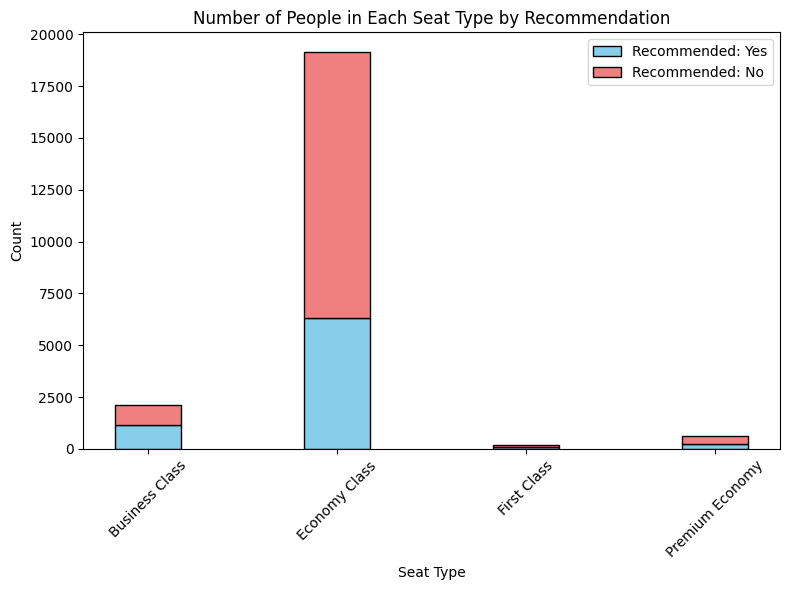

In [9]:
counts = df.groupby(['Seat Type', 'Recommended']).size().unstack(fill_value=0)

plt.figure(figsize=(8, 6))
width = 0.35
x = range(len(counts.index))
plt.bar(x, counts['yes'], width, label='Recommended: Yes', color='skyblue', edgecolor='black')
plt.bar(x, counts['no'], width, label='Recommended: No', bottom=counts['yes'], color='lightcoral', edgecolor='black')
plt.title('Number of People in Each Seat Type by Recommendation')
plt.xlabel('Seat Type')
plt.ylabel('Count')
plt.xticks(x, counts.index, rotation=45)
plt.legend()
plt.tight_layout()

plt.show()

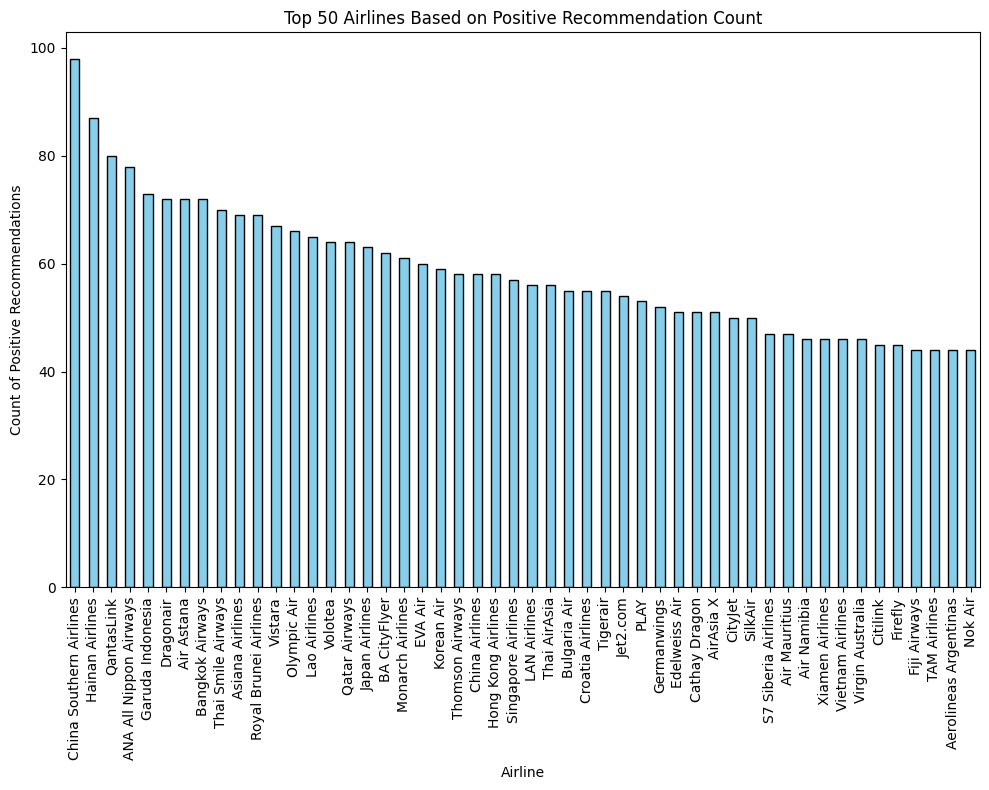

In [19]:
positive_recommendations = df[df['Recommended'] == 'yes']
airline_counts = positive_recommendations['Airline Name'].value_counts()
top_50_airlines = airline_counts.head(50)

plt.figure(figsize=(10, 8))
top_50_airlines.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Top 50 Airlines Based on Positive Recommendation Count')
plt.xlabel('Airline')
plt.ylabel('Count of Positive Recommendations')
plt.xticks(rotation=90)
plt.tight_layout()

plt.show()

In [32]:
positive_df = df[df['Recommended'] == 'yes']
max_df = positive_df[positive_df['Airline Name'] == 'China Southern Airlines']
china_southern_routes = max_df[max_df['Airline Name'] == 'China Southern Airlines']['Route'].value_counts()
most_frequent_route = china_southern_routes[china_southern_routes > 5]
print("Route details for China Southern Airlines:")
print(most_frequent_route)

Route details for China Southern Airlines:
Route
Guangzhou to Los Angeles    9
Guangzhou to London         8
Name: count, dtype: int64


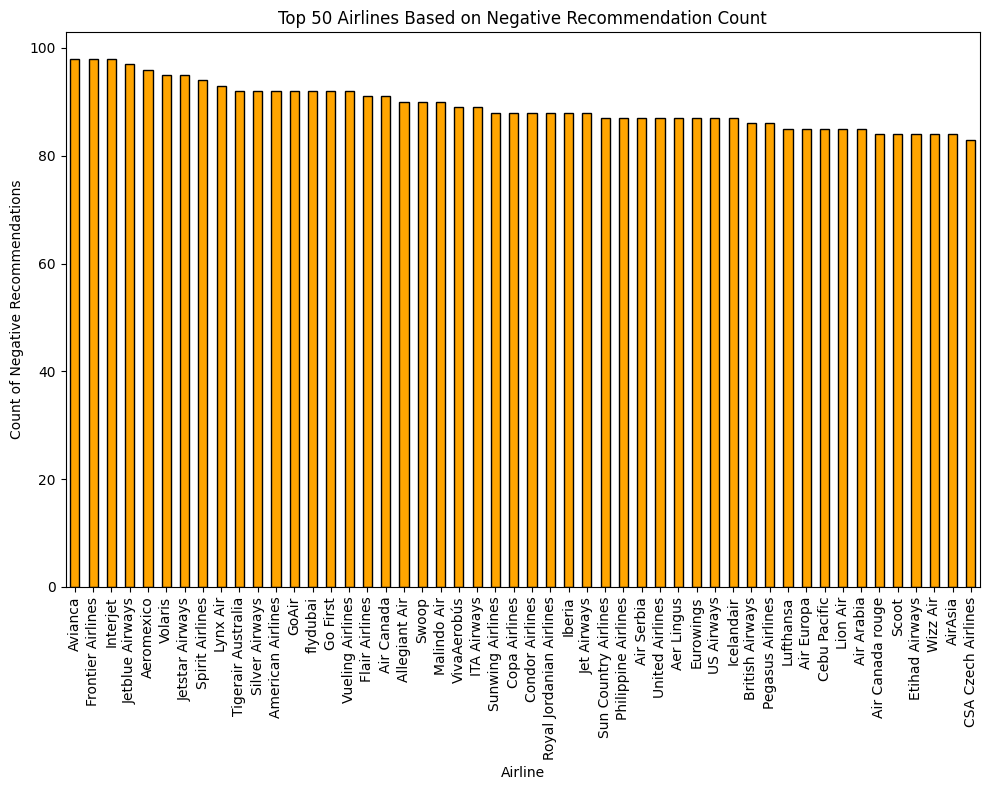

In [20]:
neg_recommendations = df[df['Recommended'] == 'no']
airline_counts = neg_recommendations['Airline Name'].value_counts()
top_50_airlines = airline_counts.head(50)

plt.figure(figsize=(10, 8))
top_50_airlines.plot(kind='bar', color='orange', edgecolor='black')
plt.title('Top 50 Airlines Based on Negative Recommendation Count')
plt.xlabel('Airline')
plt.ylabel('Count of Negative Recommendations')
plt.xticks(rotation=90)
plt.tight_layout()

plt.show()

In [36]:
neg_df = df[df['Recommended'] == 'no']
max_df = neg_df[neg_df['Airline Name'] == 'Avianca']
avianca_routes = max_df[max_df['Airline Name'] == 'Avianca']['Route'].value_counts()
most_frequent_route = avianca_routes[avianca_routes > 2]
print("Route details for Avianca:")
print(most_frequent_route)

Route details for Avianca:
Route
Bogota to Toronto     5
New York to Bogota    3
Name: count, dtype: int64


In [38]:
for i in ['yes','no']:
    recommended_reviews = df[df['Recommended'] == i]['Review']
    tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
    tfidf_matrix = tfidf_vectorizer.fit_transform(recommended_reviews)
    tfidf_scores = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
    word_scores = tfidf_scores.sum().sort_values(ascending=False)
    top_25_words = word_scores.head(25)
    if(i=='yes'):
        print("Top 25 positive review words")
    else:
        print("Top 25 negative review words")
    print(top_25_words)
    print("__________________________________________________________________")

Top 25 positive review words
flight         619.237584
good           363.931496
time           336.162312
service        329.560969
crew           300.834183
staff          271.420909
cabin          264.501071
food           252.396767
airline        244.924921
friendly       231.994316
flights        230.982763
seats          227.903546
check          227.721847
seat           217.399207
plane          201.413281
air            197.586462
aircraft       197.307924
great          197.262586
comfortable    195.687107
airlines       188.452423
experience     186.626532
nice           186.145981
airport        172.103759
class          171.083581
boarding       167.510663
dtype: float64
__________________________________________________________________
Top 25 negative review words
flight      1255.259505
airline      654.592459
service      558.753482
time         515.736018
hours        494.407847
airport      439.412107
staff        431.114904
check        417.563185
plane        410.5

In [39]:
total_nan_count = df['Seat Type'].isna().sum()
business_class_count = int(0.10 * total_nan_count)
nan_indices = df.index[df['Seat Type'].isna()].tolist()
random_indices = random.sample(nan_indices, business_class_count)
df.loc[random_indices, 'Seat Type'] = 'Business Class'
df['Seat Type'].fillna('Economy Class', inplace=True)

In [40]:
df['Recommended'] = (df['Recommended']=='yes').astype(int)
df['Year_Flown'] = df['Date Flown'].fillna('None').apply(lambda x: x[-4:])
for col in ['Airline Name', 'Aircraft', 'Type Of Traveller', 'Seat Type', 'Route', 'Year_Flown']:
    df[col] = df[col].fillna('None')
df = df.drop(['Review Date','Date Flown'], axis=1)
df.head(5)

,Airline Name,Overall_Rating,Review_Title,Verified,Review,Aircraft,Type Of Traveller,Seat Type,Route,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Inflight Entertainment,Wifi & Connectivity,Value For Money,Recommended,Year_Flown
0,AB Aviation,9,"""pretty decent airline""",True,Moroni to Moheli. Turned out to be a pretty ...,None,Solo Leisure,Economy Class,Moroni to Moheli,4.0,5.0,4.0,4.0,NaN,NaN,3.0,1,2019
1,AB Aviation,1,"""Not a good airline""",True,Moroni to Anjouan. It is a very small airline...,E120,Solo Leisure,Economy Class,Moroni to Anjouan,2.0,2.0,1.0,1.0,NaN,NaN,2.0,0,2019
2,AB Aviation,1,"""flight was fortunately short""",True,Anjouan to Dzaoudzi. A very small airline an...,Embraer E120,Solo Leisure,Economy Class,Anjouan to Dzaoudzi,2.0,1.0,1.0,1.0,NaN,NaN,2.0,0,2019
3,Adria Airways,1,"""I will never fly again with Adria""",False,Please do a favor yourself and do not fly wi...,None,Solo Leisure,Economy Class,Frankfurt to Pristina,1.0,1.0,NaN,1.0,NaN,NaN,1.0,0,2019
4,Adria Airways,1,"""it ruined our last days of holidays""",True,Do not book a flight with this airline! My fr...,None,Couple Leisure,Economy Class,Sofia to Amsterdam via Ljubljana,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,2019


In [41]:
def convert(rating):
    if rating == 'n':
        return '0'
    else:
        return rating
df['Overall_Rating'] = df['Overall_Rating'].apply(lambda x: convert(x))
df['Overall_Rating'].value_counts()

Overall_Rating
1    11587
2     2294
9     1768
8     1756
3     1353
7     1192
4      853
5      826
0      749
6      673
Name: count, dtype: int64

In [42]:
stopwords = set(stopwords.words('english'))

In [43]:
def remove_quotes(text):
    return re.sub(r'"', '', text)
def remove_stopwords(words):
    filtered_words = [word for word in words if word.lower() not in stopwords]
    return ' '.join(filtered_words)

stopwords.discard('not')

df['Review_Title'] = df['Review_Title'].apply(lambda x: x.lower())
df['Review_Title'] = df['Review_Title'].apply(remove_quotes)
df['Review_Title'] = df['Review_Title'].apply(lambda x: word_tokenize(x))
df['Review_Title'] = df['Review_Title'].apply(remove_stopwords)
df['Review_Title']

0            pretty decent airline
1                 not good airline
2         flight fortunately short
3                  never fly adria
4        ruined last days holidays
                   ...            
23166    customer service terrible
23167                  avoid costs
23168         not recommend anyone
23169           immaculately clean
23170            lost money refund
Name: Review_Title, Length: 23051, dtype: object

In [44]:
analyzer = SentimentIntensityAnalyzer()
for i in range(5):
    text = df['Review_Title'][i]+df['Review'][i]
    print(text)
    sentiment_scores = analyzer.polarity_scores(text)
    print(f"Sentiment Score: {round(sentiment_scores['compound']*10, 3)}")
    print("--------------------------------------------------------------------------------------------")

pretty decent airline  Moroni to Moheli. Turned out to be a pretty decent airline. Online booking worked well, checkin and boarding was fine and the plane looked well maintained. Its a very short flight - just 20 minutes or so so i didn't expect much but they still managed to hand our a bottle of water and some biscuits which i though was very nice. Both flights on time.
Sentiment Score: 9.342
--------------------------------------------------------------------------------------------
not good airline Moroni to Anjouan. It is a very small airline. My ticket advised me to turn up at 0800hrs which I did. There was confusion at this small airport. I was then directed to the office of AB Aviation which was still closed. It opened at 0900hrs and I was told that the flight had been put back to 1300hrs and that they had tried to contact me. This could not be true as they did not have my phone number. I was with a local guide and he had not been informed either. I presume that I was bumped off

In [45]:
df['Sentiment_Score'] = df.apply(lambda row: (analyzer.polarity_scores(row['Review_Title'] + ' ' + row['Review'])['compound'])*10, axis=1)

In [46]:
def replace_nan_with_median(col):
    median = df[col].median()
    df[col] = df[col].fillna(median)
col_with_nan = ['Seat Comfort', 'Cabin Staff Service', 'Food & Beverages', 'Ground Service', 'Value For Money']
[replace_nan_with_median(col) for col in col_with_nan]
df['Seat Type'] = df['Seat Type'].fillna('Economy Class')

In [47]:
df1 = df[['Sentiment_Score','Overall_Rating', 'Recommended', 'Seat Comfort', 'Cabin Staff Service','Food & Beverages','Ground Service','Value For Money', 'Seat Type']]
df1.head(5)

,Sentiment_Score,Overall_Rating,Recommended,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Value For Money,Seat Type
0,9.342,9,1,4.0,5.0,4.0,4.0,3.0,Economy Class
1,-8.244,1,0,2.0,2.0,1.0,1.0,2.0,Economy Class
2,3.298,1,0,2.0,1.0,1.0,1.0,2.0,Economy Class
3,-9.703,1,0,1.0,1.0,2.0,1.0,1.0,Economy Class
4,-2.626,1,0,1.0,1.0,1.0,1.0,1.0,Economy Class


In [48]:
percentage = (df.query('Recommended == 1 and Sentiment_Score >= 5.0').shape[0] / df.query('Recommended == 1').shape[0]) * 100
print(f"Percentage of rows where Recommended=1 and sentiment score is positive: {percentage:.2f}%")

Percentage of rows where Recommended=1 and sentiment score is positive: 86.63%


In [49]:
one_hot = pd.get_dummies(df1['Seat Type'], prefix='Seat Type')
one_hot = one_hot.astype(int)
df1 = pd.concat([df1, one_hot], axis=1)
df1.drop(columns=['Seat Type'], inplace=True)
df1

,Sentiment_Score,Overall_Rating,Recommended,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Value For Money,Seat Type_Business Class,Seat Type_Economy Class,Seat Type_First Class,Seat Type_Premium Economy
0,9.342,9,1,4.0,5.0,4.0,4.0,3.0,0,1,0,0
1,-8.244,1,0,2.0,2.0,1.0,1.0,2.0,0,1,0,0
2,3.298,1,0,2.0,1.0,1.0,1.0,2.0,0,1,0,0
3,-9.703,1,0,1.0,1.0,2.0,1.0,1.0,0,1,0,0
4,-2.626,1,0,1.0,1.0,1.0,1.0,1.0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
23166,-9.727,1,0,2.0,1.0,2.0,1.0,1.0,0,1,0,0
23167,-6.640,1,0,3.0,3.0,2.0,1.0,1.0,0,1,0,0
23168,-7.795,3,0,2.0,4.0,2.0,1.0,2.0,0,1,0,0
23169,9.900,6,1,3.0,4.0,3.0,1.0,5.0,1,0,0,0


In [50]:
y = df1['Recommended']
df1['Overall_Rating'] = pd.to_numeric(df1['Overall_Rating'], errors='coerce')
X = df1.drop(columns=['Recommended'])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [51]:
# List of models to train
models = {
    'Logistic Regression': LogisticRegression(),
    'Naive Bayes': GaussianNB(),
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boost': GradientBoostingClassifier(),
    'Neural Network': MLPClassifier(),
    'XGBoost': XGBClassifier(),
    'LightGBM': lgb.LGBMClassifier()
}

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


                      Feature  Importance
0             Sentiment_Score        1009
1              Overall_Rating         606
3         Cabin Staff Service         319
6             Value For Money         281
2                Seat Comfort         254
5              Ground Service         245
4            Food & Beverages         205
7    Seat Type_Business Class          36
8     Seat Type_Economy Class          22
10  Seat Type_Premium Economy          19
9       Seat Type_First Class           4
+---------------------+----------+-----------+--------+----------+-------------+-------------+--------+
|        Model        | Accuracy | Precision | Recall | F1 Score | Specificity | Exe Time(s) |  AUC   |
+---------------------+----------+-----------+--------+----------+-------------+-------------+--------+
| Logistic Regression |  0.956   |   0.9495  | 0.9206 |  0.9348  |    0.9745   |     0.23    | 0.9867 |
|     Naive Bayes     |  0.9427  |   0.9041  | 0.9316 |  0.9176  |    0.9485   |

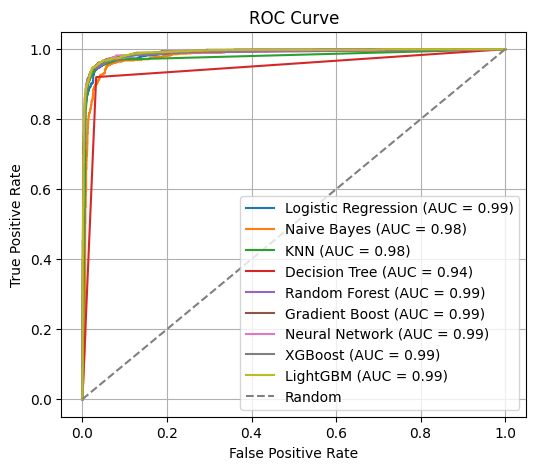

In [52]:
table = PrettyTable()
table.field_names = ["Model", "Accuracy", "Precision", "Recall", "F1 Score", "Specificity", "Exe Time(s)", "AUC"]
plt.figure(figsize=(6, 5))

for model_name, model in models.items():
    start_time = time.time()
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    
    end_time = time.time()
    execution_time = end_time - start_time
    
    if(model_name == 'LightGBM'):
        feature_importance = model.feature_importances_
        feature_names = X_train.columns
        feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
        feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
        print(feature_importance_df)

    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    
    # Calculate specificity
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
    specificity = tn / (tn + fp)
    
    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_val, model.predict_proba(X_val)[:, 1])
    auc_score = auc(fpr, tpr)

    table.add_row([model_name, round(accuracy, 4), round(precision, 4), round(recall, 4), round(f1, 4), round(specificity, 4), round(execution_time, 2), round(auc_score, 4)])
    
    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {round(auc_score, 2)})')
    
print(table)
print("---------------------------------------------------------------------------")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()